<a href="https://colab.research.google.com/github/pachterlab/FGP_2023/blob/main/toy_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Investigating Toy Systems with Unintuitive Correlation Relationships

In [13]:
from google.colab import drive
import os
import importlib.util
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

from FGP_2023.construct_H import basis_sort, create_binaries, construct_H
from FGP_2023.simulation import K_val_from_H, create_A_val, create_gamma_val, nondelay_wrapper, viz_nondelay2
from FGP_2023.noise import get_combos
from FGP_2023.moments import get_moments, calc_moments_generic

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define gene-state transition matrix, H, according to one of the toy models.
We illustrate two toy systems, characterized by transition matrices H_greater and H_reverse. These produce values of the correlation fraction, f, greater than one and less than zero respectively.

In [14]:
## Choose base-rate, k, small number delta and larger than 1 number chi.
k, delta, chi = 1, 0.1, 1.2

# Define a transition matrix with f>1.
H_greater = np.array([[-delta*k, 0, delta*k, 0],
            [0, -k, k, 0], [delta*k, k, -(2+delta)*k, k],
            [0,0,k, -k]])

# Define a transitiion matrix with f<0, i.e. reversed sign of correlation at
# transcript level compared to chromatin level.
H_reverse = np.array([[-2*delta*k, delta*k, delta*k, 0],
            [delta*k, -k*(1+delta), 0, k], [delta*k, 0, -(1+delta)*k, k],
             [0, k*chi, chi*k, -2*chi*k]])

# Choose one of the toy example transition matrices.
H = H_greater

### Simulate a set of cells long enough for the system to reach steady-state.

100%|██████████| 5000/5000 [00:58<00:00, 84.87it/s]


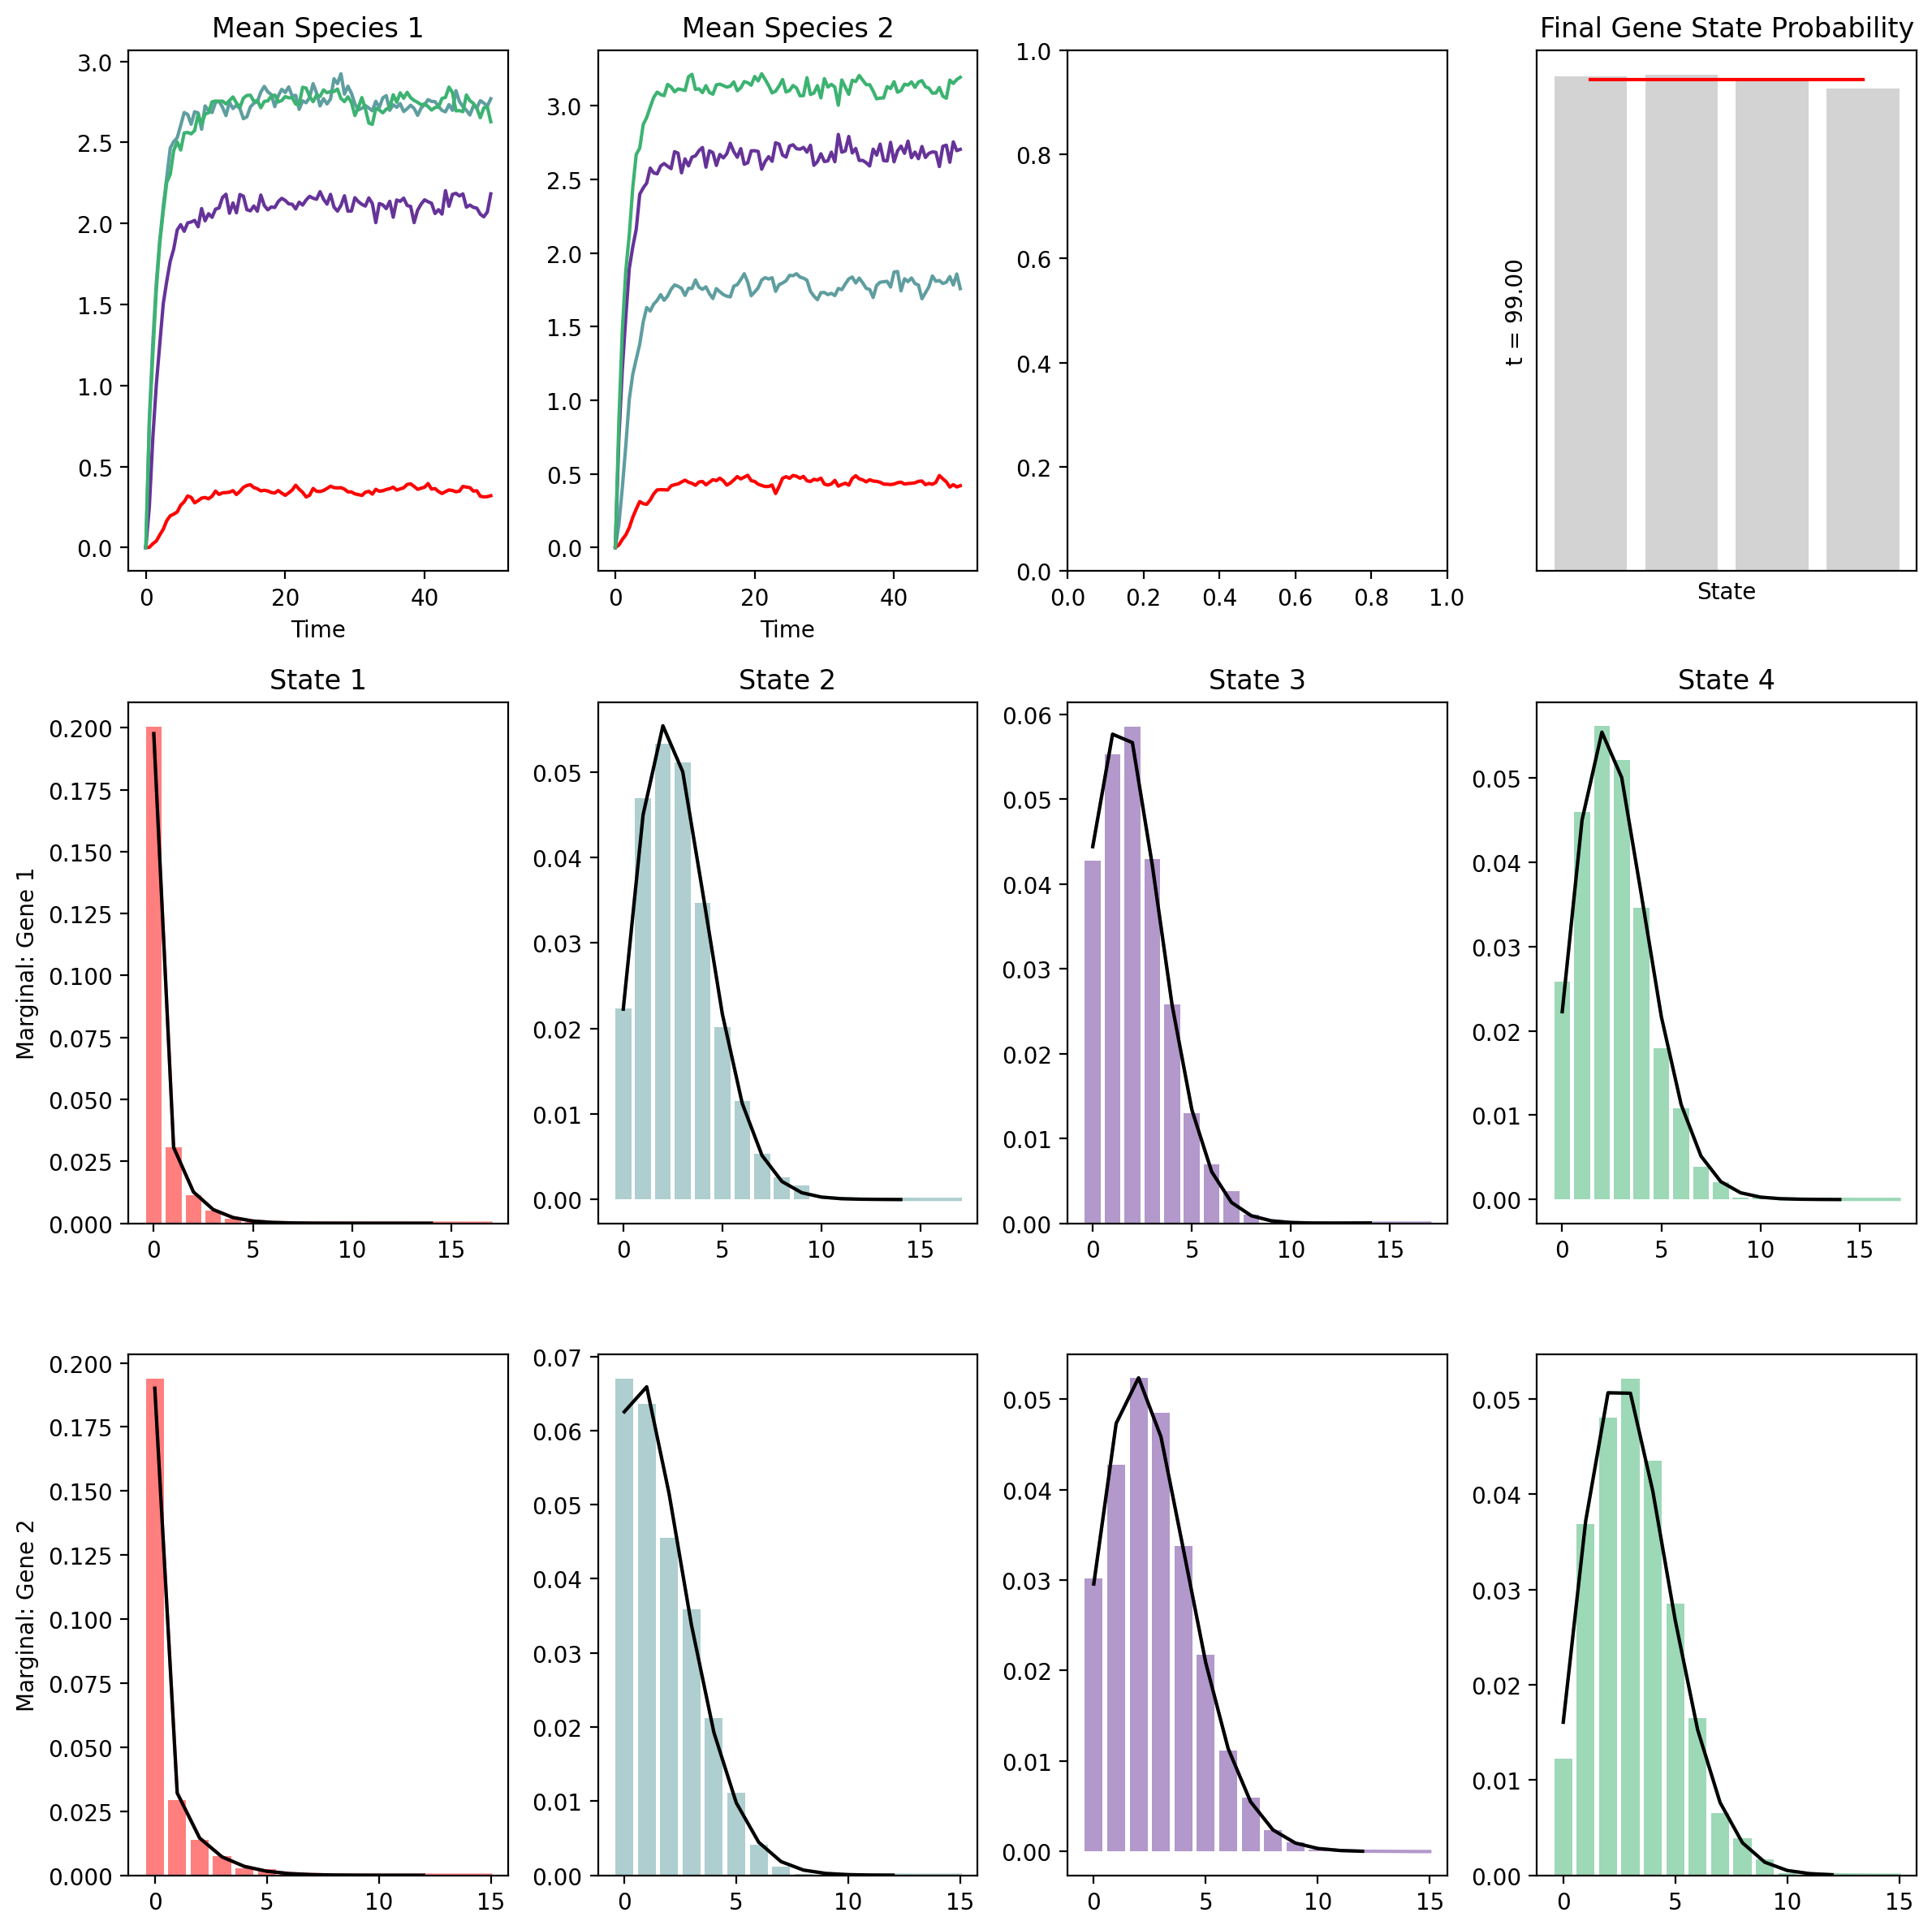

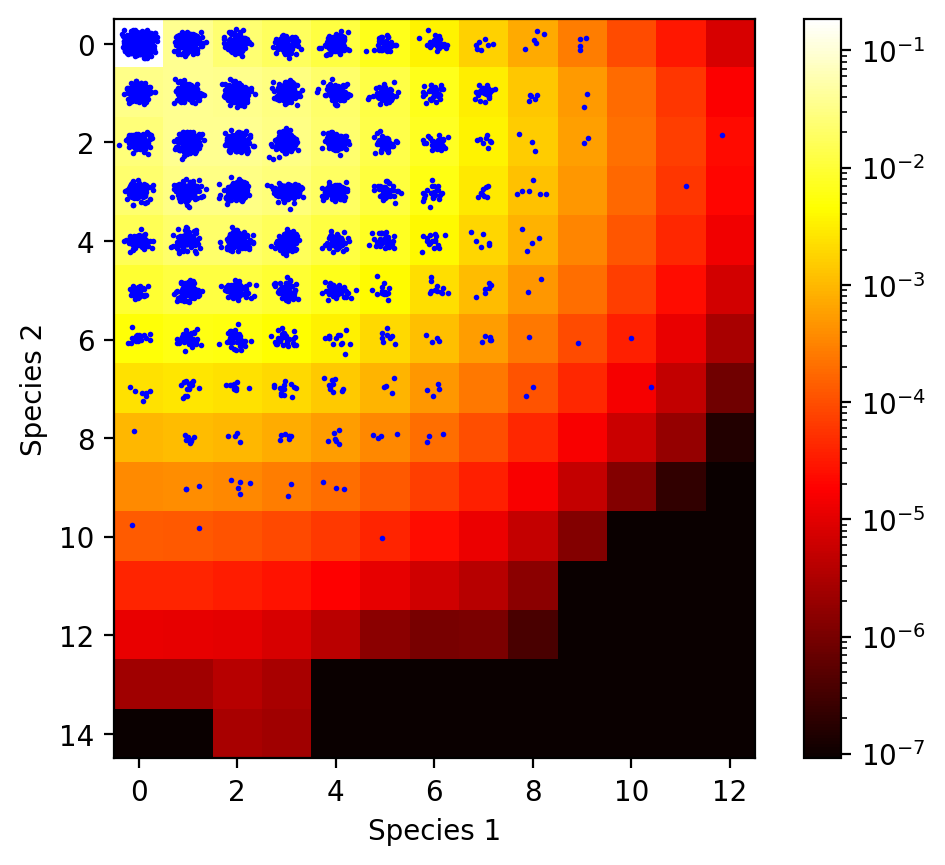

In [15]:
# Create samples from transition matrix.
K_val = K_val_from_H(H)
bs, ds = [2,2], [0.5, 0.5]
A_val, gamma_val, beta_val = create_A_val(bs), create_gamma_val(ds), [] # No splicing.
n, N = 2,4
initcond = [['thermalized']] + [['deterministic',0]]*n
number_of_cells = 5000
# Choose a simulation time inversely proportional to the slowest rate in the transition matrix.
simulation_time = 5/(delta*k)

t_arr,samples,H,A,C,init_state_prob = nondelay_wrapper(N,n,K_val,A_val,beta_val,gamma_val,initcond, simulation_time=simulation_time, number_of_cells=number_of_cells, ndel=100)
# Uncomment to visualize the system.
viz_nondelay2(t_arr,samples,N,n,H,A,C,initcond,init_state_prob);

### Calculate moments of transcript numbers and site openness values from simulated data.
We assume that, at late times, the system is thermalized and sampling at sufficiently separated times is equivalent to sampling independent cells in equilibrium.

In [16]:
## Take random time slices from the latter times of the sampling
# (we are relying on thermalization such that different times can be used as different samples)
moment_values = []
for t in range(int(len(t_arr)/5*2), len(t_arr)):
  time_slice = samples[:,t,:]
  moment_values += [get_moments(time_slice, (0,1), 2)]

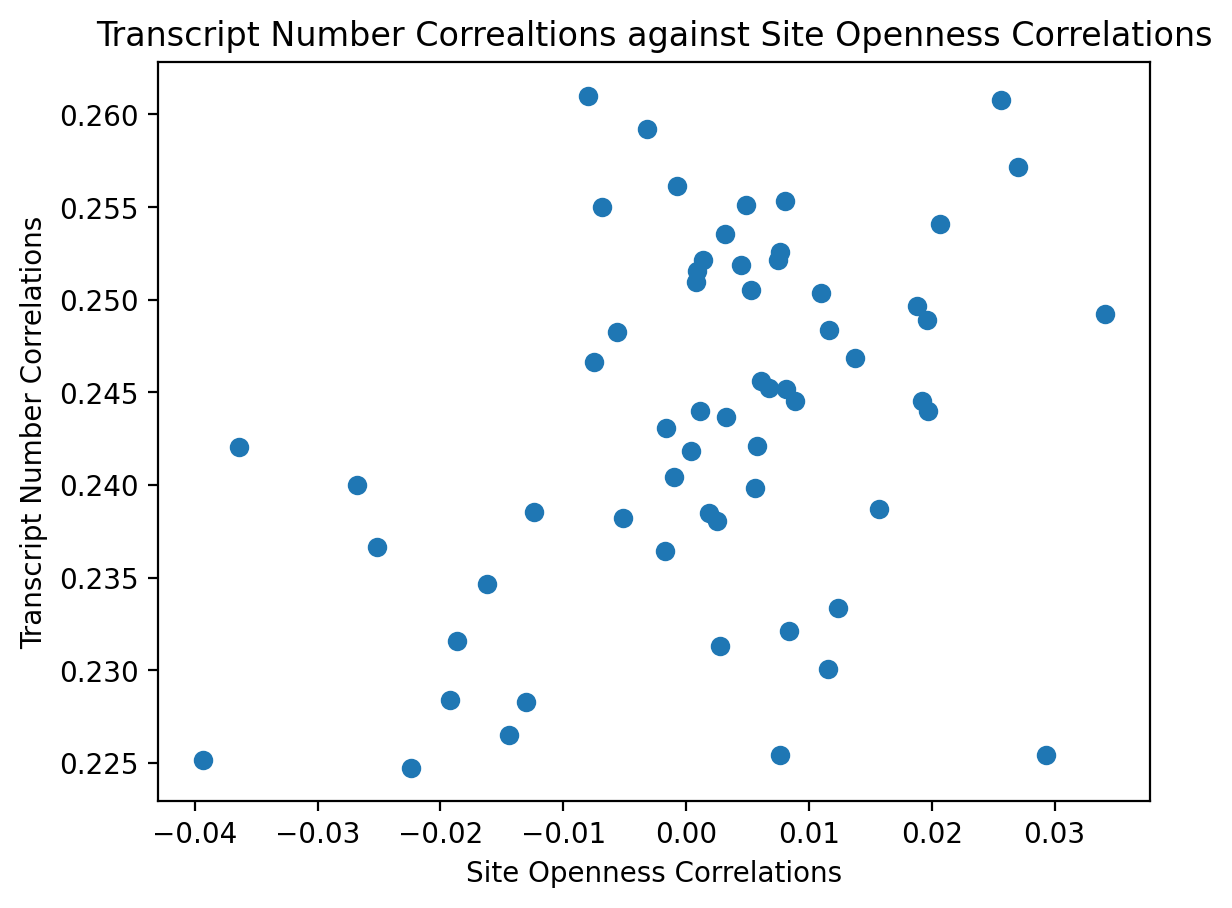

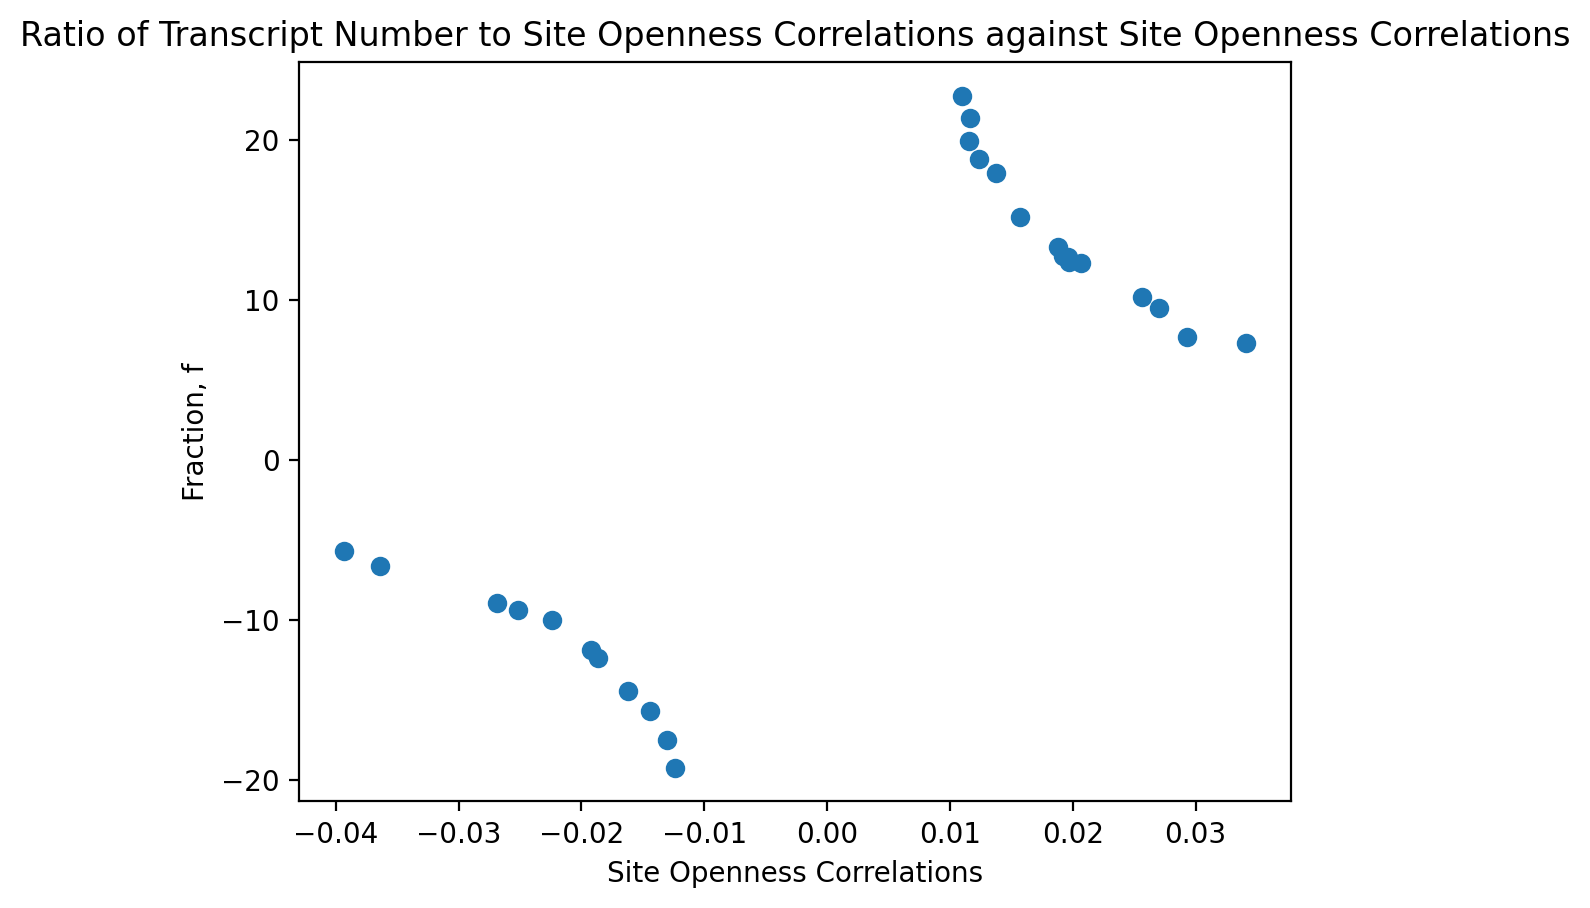

Average Transcript Number Correlation: 0.2434248503619951
Average Site Openness Correlation: 0.001968332771216516
Ratio of Average Correlations, f_av: 123.67057741539702


In [17]:
## Plot transcript correlation vs site correlation for all time-slices.

trans_corrs = [moms['transcript_corr'] for moms in moment_values]
site_corrs = [moms['site_corr'] for moms in moment_values]
plt.scatter(site_corrs, trans_corrs)
plt.xlabel('Site Openness Correlations')
plt.ylabel('Transcript Number Correlations')
plt.title('Transcript Number Correlations against Site Openness Correlations')
plt.show()

# Exclude examples where site_corrs are close to zero for visualizing f.
threshold = 0.01
indices_to_exclude = np.where(np.abs(site_corrs) < threshold)[0]
filtered_site_corrs = np.delete(site_corrs, indices_to_exclude)
filtered_trans_corrs = np.delete(trans_corrs, indices_to_exclude)

fs = [i/j for i, j in zip(filtered_trans_corrs, filtered_site_corrs)]
plt.scatter(filtered_site_corrs, fs)
plt.xlabel('Site Openness Correlations')
plt.ylabel('Fraction, f')
plt.title('Ratio of Transcript Number to Site Openness Correlations against Site Openness Correlations')
plt.show()

trans_av, site_av = np.mean(trans_corrs), np.mean(site_corrs)
print('Average Transcript Number Correlation:', trans_av)
print('Average Site Openness Correlation:', site_av)
print('Ratio of Average Correlations, f_av:', trans_av/site_av)

## Check against analytic result

In [18]:
sites = (0,1)
calculated_moments = calc_moments_generic(H, bs, ds, sites)
trans_corr, site_corr, f = calculated_moments['transcript_corr'], calculated_moments['site_corr'], calculated_moments['f']
print('Analytic Results:')
print('Transcript Number Correlation:', trans_corr)
print('Site Openness Correlation:', site_corr)
print('Correlation Fraction, f:', f)


Analytic Results:
Transcript Number Correlation: 0.24406583343411326
Site Openness Correlation: 0.0
Correlation Fraction, f: inf


/content/drive/MyDrive/Colab Notebooks/FGP_2023/moments.py:207: RuntimeWarning: divide by zero encountered in double_scalars
  f = transcript_corr/site_corr
